In [1]:
import my_plotting
import markers
import importlib
import utils
import covax_constants
import CovidVAX_specific_utils
import GeneModules
import better_plotting

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np

import warnings
warnings.simplefilter("ignore")

from functools import partial
import scanpy as sc

import muon as mu
import anndata

In [2]:
myeloid = sc.read_h5ad('myeloid_1.h5ad')

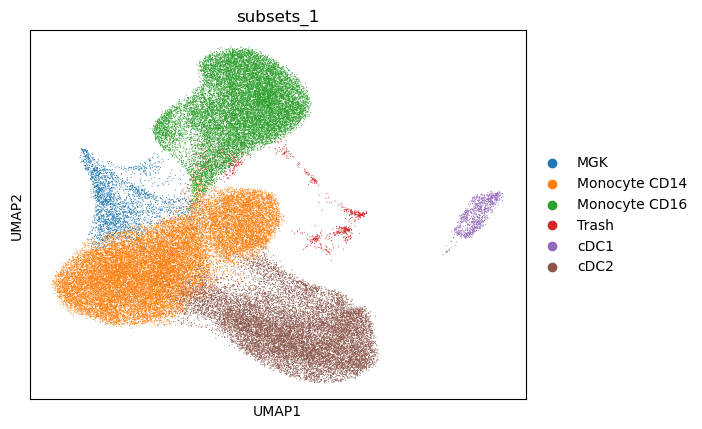

In [3]:
sc.pl.umap(myeloid, color = ['subsets_1'])

In [4]:
myeloid

AnnData object with n_obs × n_vars = 58164 × 17703
    obs: 'pt_id', 'day', 'clustnm', 'sample_id', 'n_genes', 'person', 'Visit', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'is_outlier', 'l070', 'l070_1', 'subsets_1'
    var: 'n_cells', 'is_rna', 'is_protein', 'highly_variable', 'mean', 'std'
    uns: 'Visit_colors', 'clustnm_colors', 'l070_1_colors', 'l070_colors', 'leiden', 'neighbors', 'pca', 'person_colors', 'sample_id_colors', 'subsets_1_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'connectivities', 'distances'

In [5]:
adata = myeloid[myeloid.obs.subsets_1 == 'Monocyte CD16'].copy()

In [6]:
rna = adata[:, adata.var.is_rna].copy()

In [7]:
rna.X = rna.layers['counts'].copy()

In [8]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)

sc.pp.highly_variable_genes(rna, batch_key='person')

In [9]:
adt = adata[:, adata.var.is_protein].copy()

adt.X = adt.layers['normalized'].copy()

In [10]:
adt.var['highly_variable'] = False

In [11]:
combined = anndata.concat([rna, adt], axis = 1)

In [12]:
combined.obs[rna.obs.columns] = rna.obs.copy()

In [13]:
combined.layers['normalized'] = combined.X.copy()

In [14]:
sc.pp.scale(combined, max_value=10)
sc.tl.pca(combined, svd_solver='arpack', use_highly_variable=True)

In [15]:
# sc.pp.neighbors(combined, n_pcs=25)
sc.external.pp.bbknn(combined, batch_key='person', n_pcs=20)
sc.tl.umap(combined)

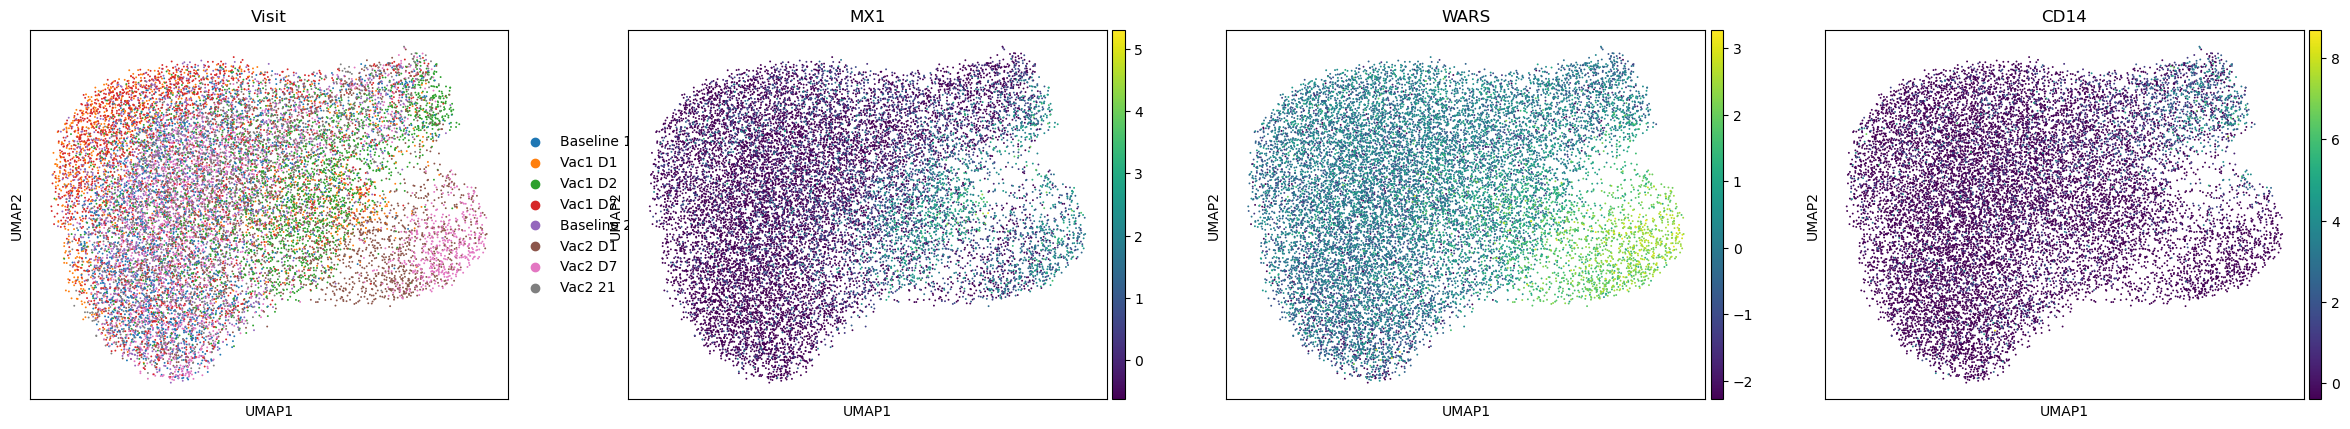

In [16]:
sc.pl.umap(combined, color = ['Visit', 'MX1', 'WARS', 'CD14'])

In [17]:
sc.tl.leiden(combined, resolution=.2, key_added = 'l020')

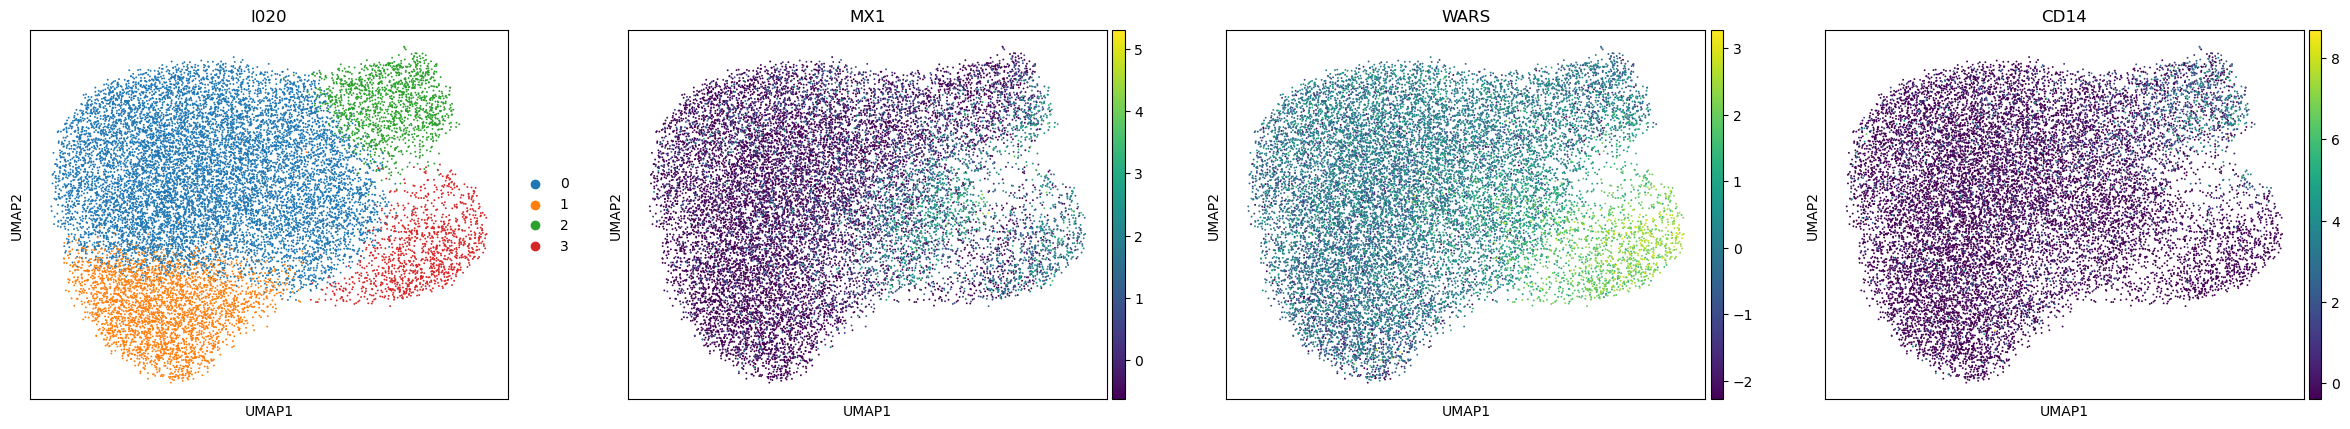

In [18]:
sc.pl.umap(combined, color = ['l020', 'MX1', 'WARS', 'CD14'])

In [19]:
combined.obs['subsets'] = combined.obs['l020'].map({
    '0' : 'CD16',
    '1' : 'CD16',
    '2' : 'Intermediate',
    '3' : 'CD16 ISG High',
})

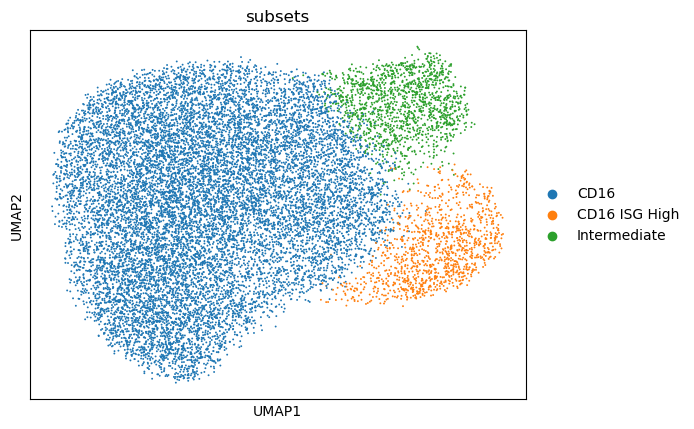

In [20]:
sc.pl.umap(combined, color = ['subsets'])

In [21]:
combined_1 = combined[~combined.obs['subsets'].isin({'Intermediate', 'CD16 ISG High'})].copy()

In [22]:
sc.tl.leiden(combined_1, resolution=.4, key_added = 'leiden')

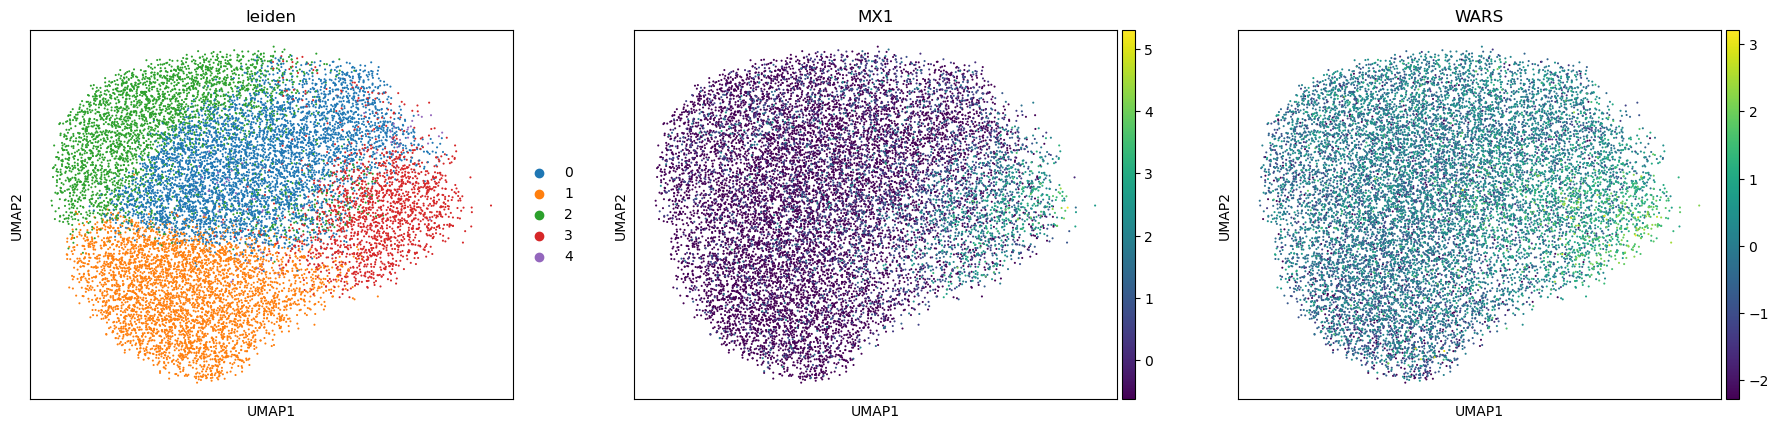

In [23]:
sc.pl.umap(combined_1, color = ['leiden', 'MX1', 'WARS'])

In [24]:
combined_1.obs['subsets'] = combined_1.obs['leiden'].map({
    '0' : 'CD16',   
    '1' : 'CD16',  
    '2' : 'CD16',  
    '3' : 'CD16 ISG Dim',  
    '4' : 'CD16',  
})

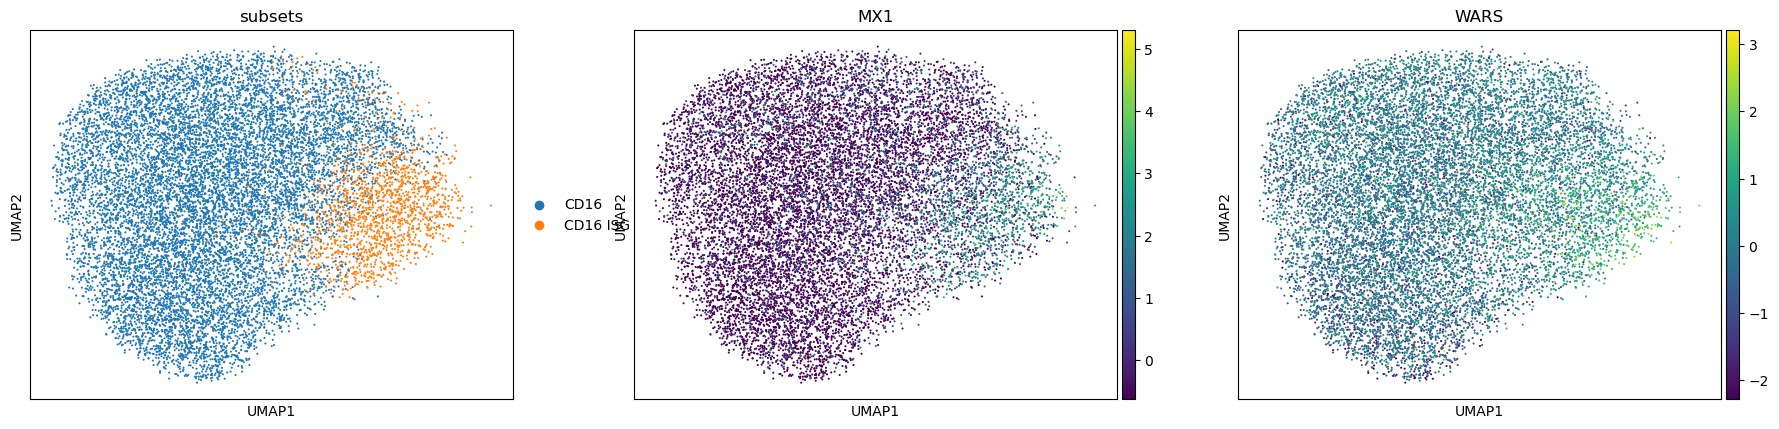

In [25]:
sc.pl.umap(combined_1, color = ['subsets', 'MX1', 'WARS'])

In [26]:
combined.obs['subsets_1'] = combined.obs['subsets'].astype(str)
combined.obs.loc[combined_1.obs_names, 'subsets_1'] = combined_1.obs['subsets'].astype(str)

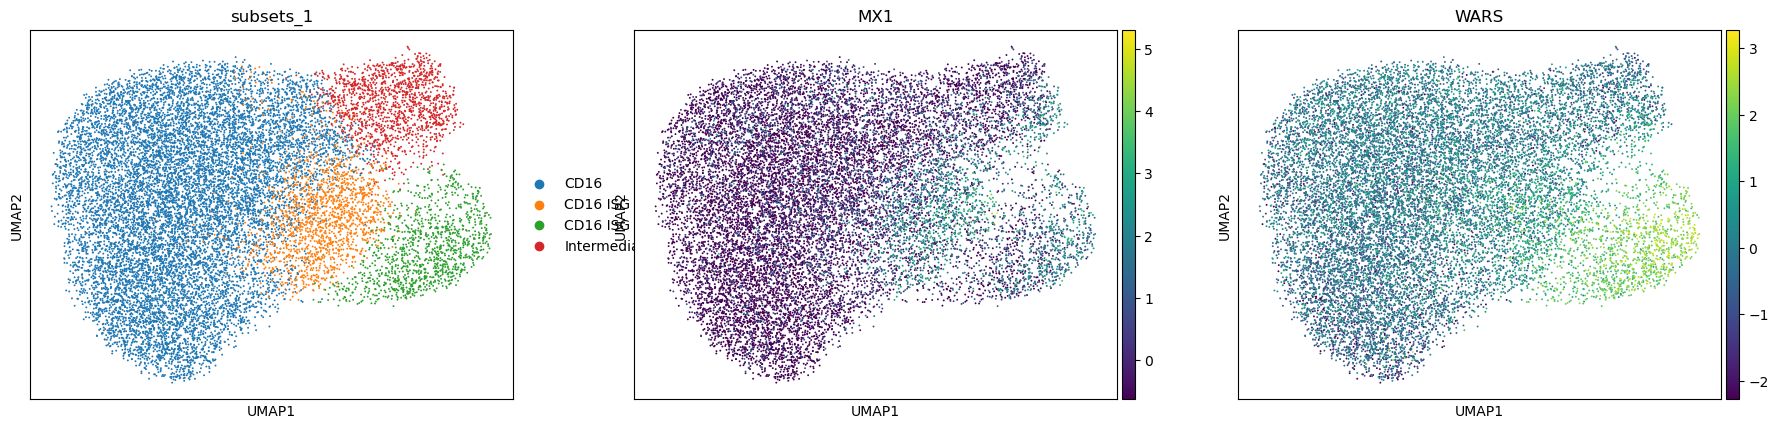

In [27]:
sc.pl.umap(combined, color = ['subsets_1', 'MX1', 'WARS'])

In [28]:
genes_dict = {
	'High Specific' : ['PSMB9', 'FRMD3', 'DYSF', 'CAMK2D', 'SAMD4A', 'SECTM1', 'FARP2', 'NCF1', 'MYOF', 'APOL3', 'LIMK2', 'GBP1', 'WARS', 'GBP5', 'GBP2', 'LAP3', 'GCH1', 'FCGR1A', 'PSTPIP2', 'PSMA4', 'CALHM6', 'TCF7L2', 'ANKRD22', 'GBP4', 'VAMP5', 'PSME2', 'PSMB10', 'ARID5B', 'BCL2A1', 'PLAC8', 'IFITM3', 'MT2A', 'IL31RA'],
	'High and Dim' : ['ISG15', 'EPSTI1', 'DDX60', 'PARP14', 'PARP9', 'IFIH1', 'STAT2', 'TRIM22', 'RNF213', 'SP110', 'TRIM25', 'CD2AP', 'ZC3HAV1', 'IFI16', 'ADAR', 'SMCHD1'],
	'Dim Specific' : ['IFI44', 'MX1', 'MX2', 'ZCCHC2', 'TENT5A', 'EIF2AK2', 'KIAA1958', 'ITSN1', 'IFI44L', 'COA1', 'DDX58', 'HERC5'],
	'Dim and Low' : ['NLRP12', 'TIAM1', 'PITPNC1', 'S100Z', 'LDLRAD4', 'TRERF1', 'ST6GALNAC3', 'SSBP2', 'CSF3R', 'TMEM71', 'CD99', 'TBC1D9', 'F13A1', 'FOXO1', 'PECAM1', 'ZFHX3', 'TREM1', 'RFX2', 'FOSL2', 'CLMN', 'SGMS2'],
}
# FAM13A is not in Bali's data

In [29]:
combined.obs['subsets_1'] = pd.Categorical(combined.obs['subsets_1'], categories=['CD16 ISG High', 'CD16 ISG Dim', 'CD16', 'Intermediate'])

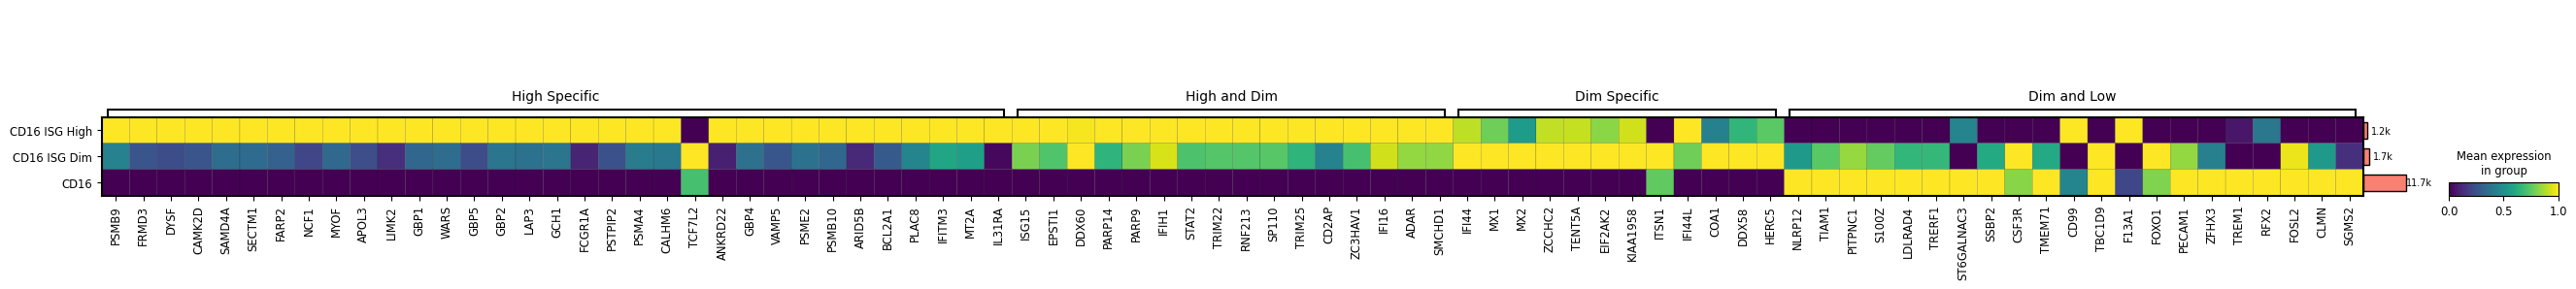

In [30]:
mp = sc.pl.matrixplot(combined[combined.obs['subsets_1']!='Intermediate'], 
              genes_dict, 
              groupby = 'subsets_1', 
              var_group_rotation = 0,
              standard_scale = 'var',
              return_fig=True,
             )

mp.add_totals().style(edge_color='black').show()
fig = mp.fig
# my_plotting.savefig_png_eps(fig, 'cDC2_subsets_isg_matrixplot_2', make_folder=True, use_timestamp=False)

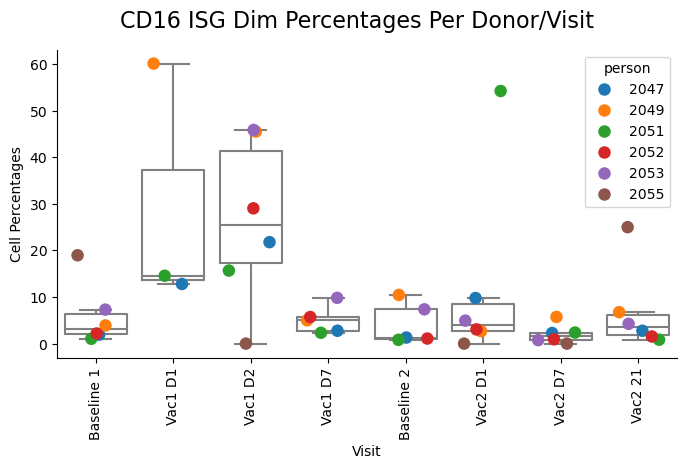

In [31]:
better_plotting.cell_proportions_longitudinal_box_plot(combined[combined.obs['subsets_1']!='Intermediate'], 'CD16 ISG Dim', 'subsets_1');

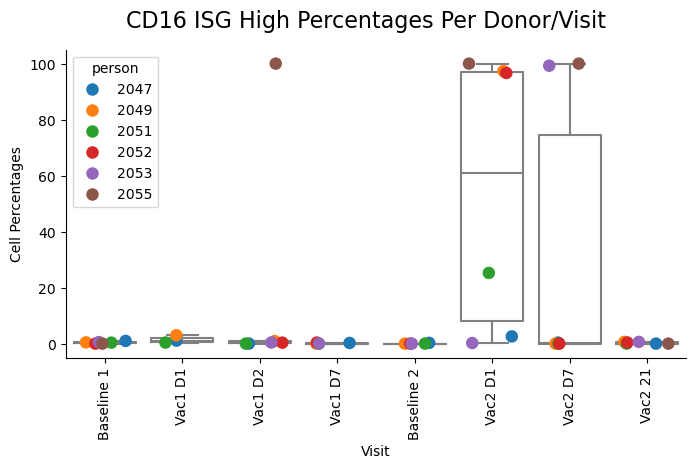

In [32]:
better_plotting.cell_proportions_longitudinal_box_plot(combined[combined.obs['subsets_1']!='Intermediate'], 'CD16 ISG High', 'subsets_1');

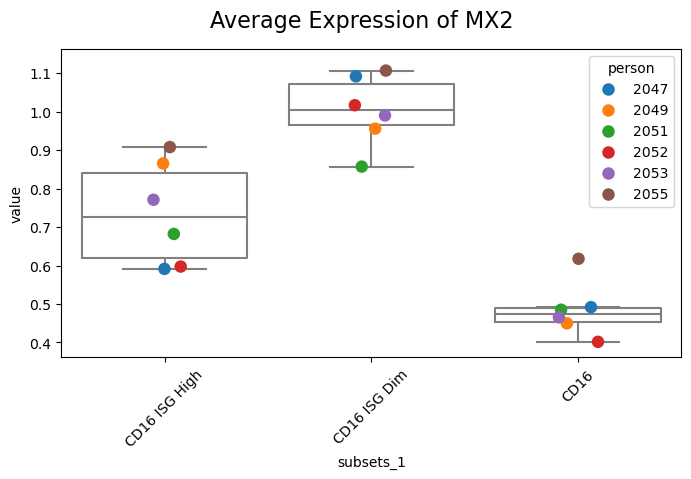

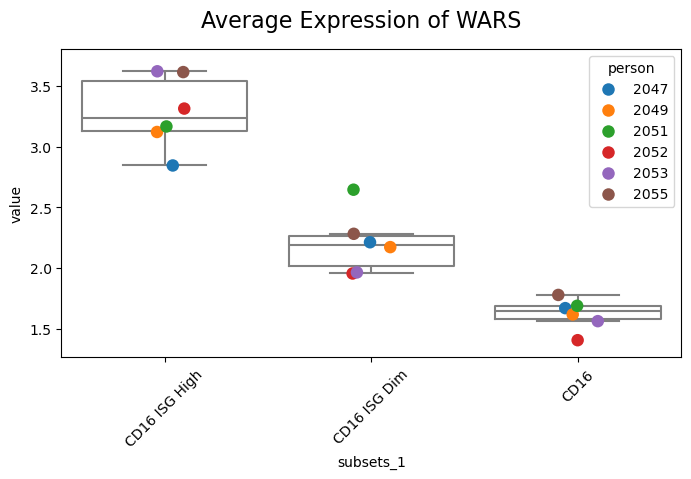

In [34]:
# better_plotting.compare_groups(combined[combined.obs['subsets_1']!='Intermediate'], 'MX1', 'subsets_1', layer='normalized', use_raw=False);
better_plotting.compare_groups(combined[combined.obs['subsets_1']!='Intermediate'], 'MX2', 'subsets_1', layer='normalized', use_raw=False);
better_plotting.compare_groups(combined[combined.obs['subsets_1']!='Intermediate'], 'WARS', 'subsets_1', layer='normalized', use_raw=False);
# better_plotting.compare_groups(combined[combined.obs['subsets_1']!='Intermediate'], 'GBP2', 'subsets_1', layer='normalized', use_raw=False);

In [35]:
cd16 = combined[combined.obs['subsets_1']!='Intermediate'].copy()

In [36]:
cd16.write_h5ad('CD16.h5ad')

In [38]:
myeloid.obs['subsets_2'] = myeloid.obs['subsets_1'].astype(str)
myeloid.obs.loc[combined.obs_names, 'subsets_2'] = combined.obs['subsets_1']

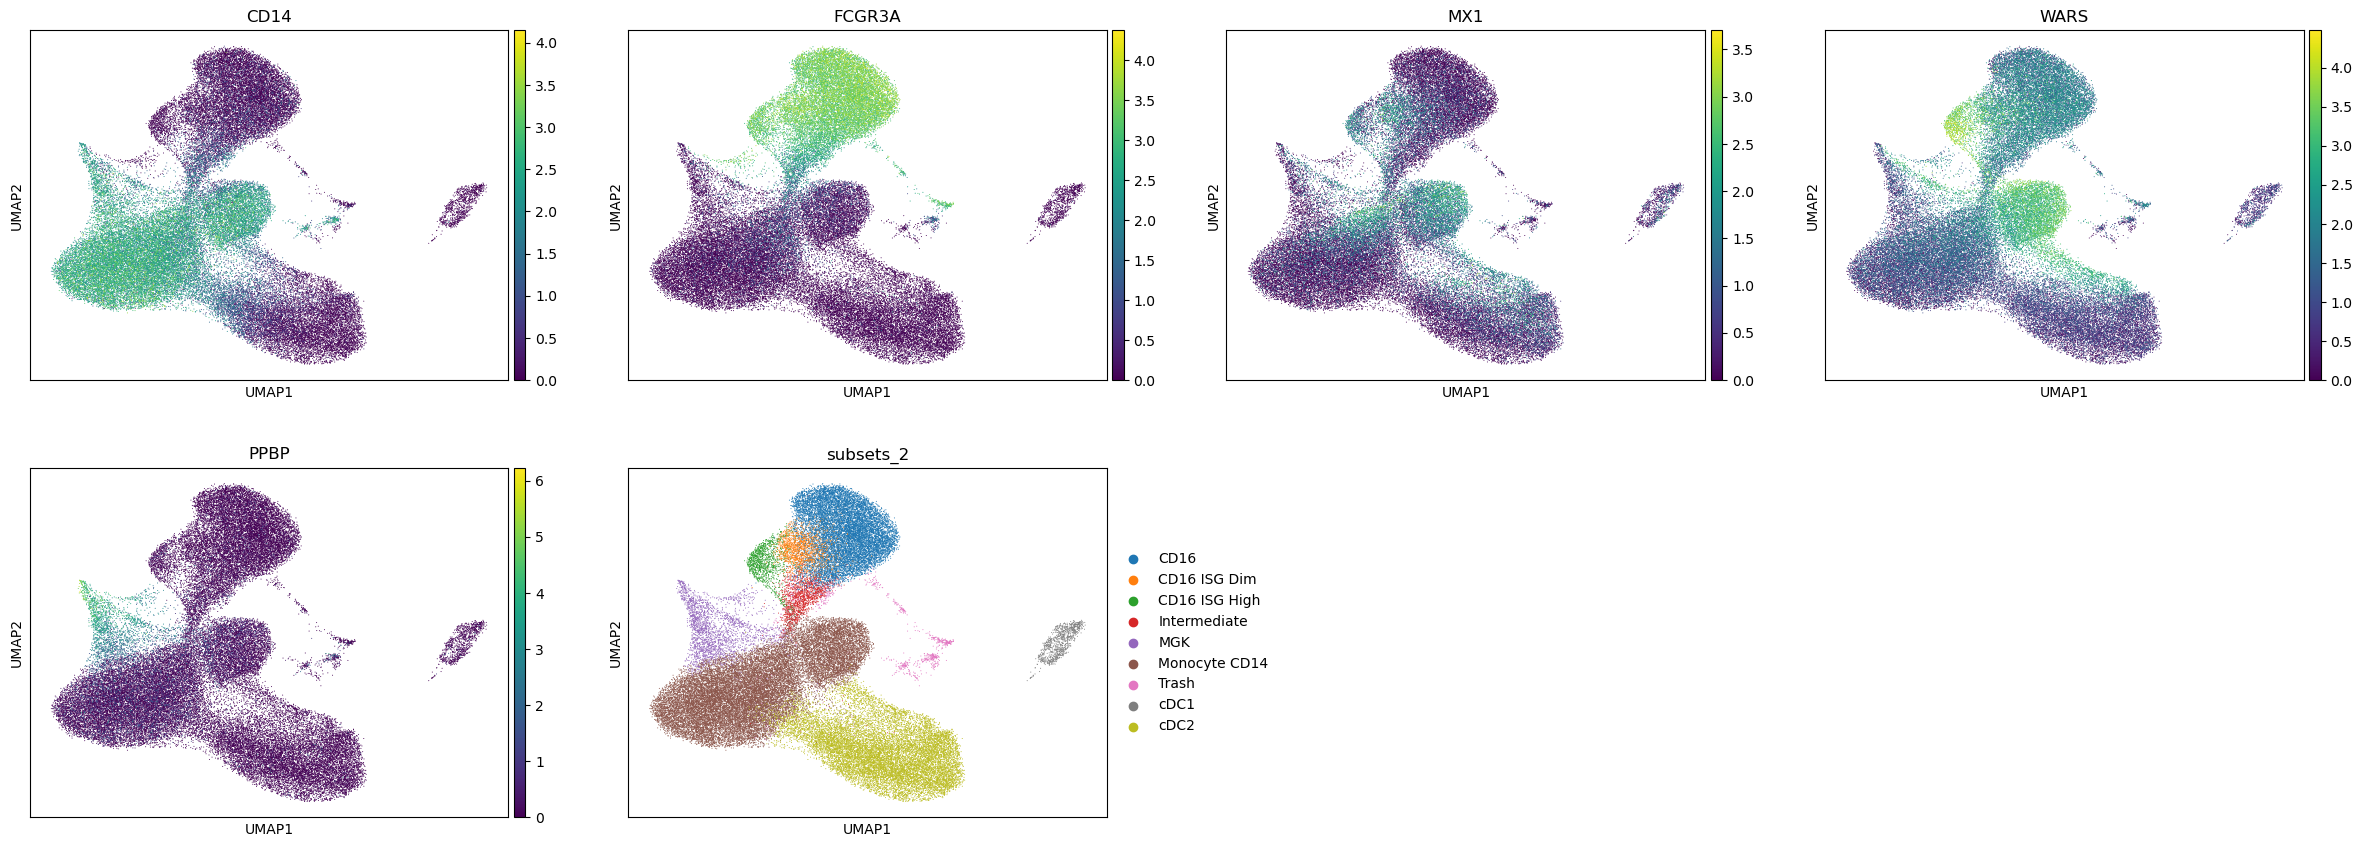

In [39]:
sc.pl.umap(myeloid, color = ['CD14', 'FCGR3A', 'MX1', 'WARS', 'PPBP', 'subsets_2'], layer='normalized')